# Eta Offset exploration

Separating out eta offset exploration in a new notebook to avoid rerunning everything else over and over....

In [1]:
# startup
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
%matplotlib inline
import babysmurf as bs

In [2]:
fsig = 0.5 # 0.5 Hz signal

tvec = np.linspace(0,0.5,25) # create half second of data
sig = np.sin(2 * np.pi * (1/fsig) * tvec)

scalefac = 0.1 # this is quite big; most signals are smaller than this
scaledsig = scalefac * sig

squid = bs.make_squid_curve(0.33,100.e3) # lambda = 0.33, 100kHz peak to peak frequency swing

m,t,ph = bs.make_measured_signal(tvec,scaledsig,squid,reset_rate=4.e3) # take nphi0=4, fsamp = 2.4MHz as defaults, but 4kHz reset rate as is common

In [3]:
# go back to use an ideal resonator here
fres = 5.5e9 # 5.5GHz
Qtot = 5.5e4
Qc = 4.e4 # now this is complex
fvec = np.linspace(fres-60.e3,fres+60.e3,int(3e2))

matmag,matphase = bs.make_s21_measurement(fvec,fres + m,Qtot,Qc)

In [5]:
# estimate eta using the state at time = 0
offset = 20.e3 # 20 kHz offset
eta = bs.estimate_eta(fvec,matmag[:,0],matphase[:,0],offset=offset)

In [6]:
offset_angles = [10,20,30,40,50,60,70] # degrees
demods = np.zeros((2000,len(offset_angles)))
for ii in range(len(offset_angles)):
    matphase2 = np.exp(1j*np.deg2rad(offset_angles[ii])) * matphase
    dd,_,_,_,_ = bs.lms_fit_demod_track(np.transpose(matmag),np.transpose(matphase2),fvec,eta,reset_rate=4.e3)
    demods[:,ii] = np.ravel(dd)

Text(0.5, 1.0, 'Resonance rotated, constant eta')

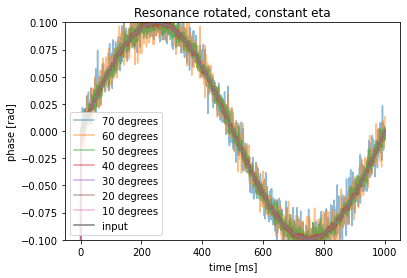

In [7]:
tt = np.linspace(0,len(dd)/len(ph),len(dd))

for ii in range(len(offset_angles)):
    plt.plot(tt*1e3,demods[:,len(offset_angles)-1-ii] - np.mean(demods[:,len(offset_angles)-1-ii]),label=f'{offset_angles[len(offset_angles)-1-ii]} degrees',alpha=0.5)
plt.plot(tt*1e3,ph[:len(dd)] - np.mean(ph[:len(dd)]),label='input')
plt.xlabel('time [ms]')
plt.ylabel('phase [rad]')
plt.ylim([-0.1,0.1])
plt.legend()
plt.title('Resonance rotated, constant eta')

In [8]:
def rms(array):
    return np.sqrt(np.mean(np.power(array,2)))

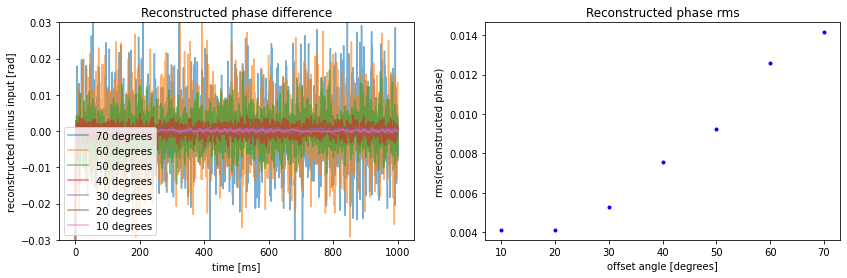

In [11]:
tt = np.linspace(0,len(dd)/len(ph),len(dd))
fig,ax = plt.subplots(1,2,figsize=(14,4))
for ii in range(len(offset_angles)):
    ax[0].plot(tt*1e3,demods[:,len(offset_angles)-1-ii] - np.mean(demods[:,len(offset_angles)-1-ii]) - (ph[:len(dd)] - np.mean(ph[:len(dd)])),label=f'{offset_angles[len(offset_angles)-1-ii]} degrees',alpha=0.6)
#plt.plot(tt*1e3,ph[:len(dd)] - np.mean(ph[:len(dd)]),label='input')
ax[0].set_xlabel('time [ms]')
ax[0].set_ylabel('reconstructed minus input [rad]')
ax[0].set_ylim([-0.03,0.03])
ax[0].legend()
ax[0].set_title('Reconstructed phase difference')

for ii in range(len(offset_angles)):
    ax[1].plot(offset_angles[ii],rms(demods[:,ii]- np.mean(demods[:,ii]) - ph[:len(dd)] - np.mean(ph[:len(dd)])),'b.')
#ax[1].plot([0],rms(ph[:len(dd)] - np.mean([ph[:len(dd)]]) - ph[:len(dd)]),'b.')
ax[1].set_xlabel('offset angle [degrees]')
ax[1].set_ylabel('rms(reconstructed phase)')
ax[1].set_title('Reconstructed phase rms')

plt.savefig('plots/eta_offset.png',bbox_inches='tight')
plt.savefig('plots/eta_offset.svg',bbox_inches='tight')

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
for ii in range(len(offset_angles)):
    ax.hist(demods[10:,len(offset_angles)-1-ii] - np.mean(demods[10:,len(offset_angles)-1-ii]) - (ph[10:len(dd)] - np.mean(ph[10:len(dd)])),label=f'{offset_angles[len(offset_angles)-1-ii]} degrees',alpha=0.6,bins=20)
#plt.plot(tt*1e3,ph[:len(dd)] - np.mean(ph[:len(dd)]),label='input')
ax.legend()
ax.set_xlabel('reconstructed minus input [rad]')
ax.set_ylabel('counts')
ax.set_title('histogram of (reconstructed - input)')

plt.savefig('plots/eta_offset_hist.png',bbox_inches='tight')
plt.savefig('plots/eta_offset_hist.svg',bbox_inches='tight')